In [1]:
import pandas as pd

from agent import DDPGAgent
from config import Config
from data import DataLoader
from env import Env
from eval import Evaluator
from utils import OUNoise
import matplotlib.pyplot as plt


In [2]:
def train(config: Config, env: Env, agent: DDPGAgent, evaluator: Evaluator,
          df_eval_user: pd.DataFrame(), df_eval_group: pd.DataFrame()):
    """
    Train the agent with the environment

    :param config: configurations
    :param env: environment
    :param agent: agent
    :param evaluator: evaluator
    :param df_eval_user: user evaluation data
    :param df_eval_group: group evaluation data
    :return:
    """
    rewards = []
    recall_scores = {top_K: [] for top_K in config.top_K_list}
    ndcg_scores = {top_K: [] for top_K in config.top_K_list}
    # config num_episodes = 10 # for testing
    for episode in range(config.num_episodes):
        state = env.reset()
        agent.noise.reset()
        episode_reward = 0

        for step in range(config.num_steps):
            action = agent.get_action(state)
            new_state, reward, _, _ = env.step(action)
            agent.replay_memory.push((state, action, reward, new_state))
            state = new_state
            episode_reward += reward

            if len(agent.replay_memory) >= config.batch_size:
                agent.update()

        rewards.append(episode_reward / config.num_steps)
        print('Episode = %d, average reward = %.4f' % (episode, episode_reward / config.num_steps))
        if (episode + 1) % config.eval_per_iter == 0:
            for top_K in config.top_K_list:
                avg_recall_score, avg_ndcg_score = evaluator.evaluate(agent=agent, df_eval=df_eval_group, mode='group', top_K=top_K)
                recall_scores[top_K].append((episode, avg_recall_score))
                ndcg_scores[top_K].append((episode, avg_ndcg_score))
    
    return recall_scores, ndcg_scores

In [3]:
%%time
config = Config()
dataloader = DataLoader(config)
rating_matrix_train = dataloader.load_rating_matrix(dataset_name='val')
df_eval_user_test = dataloader.load_eval_data(mode='user', dataset_name='test')
df_eval_group_test = dataloader.load_eval_data(mode='group', dataset_name='test')
env = Env(config=config, rating_matrix=rating_matrix_train, dataset_name='val')
noise = OUNoise(config=config)
agent = DDPGAgent(config=config, noise=noise, group2members_dict=dataloader.group2members_dict, verbose=True)
evaluator = Evaluator(config=config)
recall_scores, ndcg_scores = train(config=config, env=env, agent=agent, evaluator=evaluator,
        df_eval_user=df_eval_user_test, df_eval_group=df_eval_group_test)

Read data: data/MovieLens-Rand/userRatingVal.dat
Read data: data/MovieLens-Rand/userRatingTrain.dat
Read data: data/MovieLens-Rand/groupRatingVal.dat
Read data: data/MovieLens-Rand/groupRatingTrain.dat
Load data: saves/eval_user_test_5.pkl
Load data: saves/eval_group_test_5.pkl
Load environment: saves/env_val_32.npy
Embedding(
  (user_embedding): Embedding(6041, 32)
  (item_embedding): Embedding(3953, 32)
  (user_attention): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (user_softmax): Softmax(dim=-1)
)
Actor(
  (net): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
)
Critic(
  (net): Sequential(
    (0): Linear(in_features=224, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3

In [4]:
top_k_5_scores = recall_scores[5]
max_recall_5_episode = max(top_k_5_scores, key=lambda x: x[1])[0]

max_values = {top_K: max([score for ep, score in scores if ep == max_recall_5_episode])
              for top_K, scores in recall_scores.items()}
print(f"Max Recall scores at episode {max_recall_5_episode} (where Recall@5 is max):")
for top_K, value in max_values.items():
    print(f"  Max Recall@{top_K}: {value:.4f}")

max_values = {top_K: max([score for ep, score in scores if ep == max_recall_5_episode])
              for top_K, scores in ndcg_scores.items()}

for top_K, value in max_values.items():
    print(f"  Max NDCG@{top_K}: {value:.4f}")

Max Recall scores at episode 9 (where Recall@5 is max):
  Max Recall@5: 0.0489
  Max Recall@10: 0.1041
  Max Recall@20: 0.2027
  Max NDCG@5: 0.0267
  Max NDCG@10: 0.0444
  Max NDCG@20: 0.0689


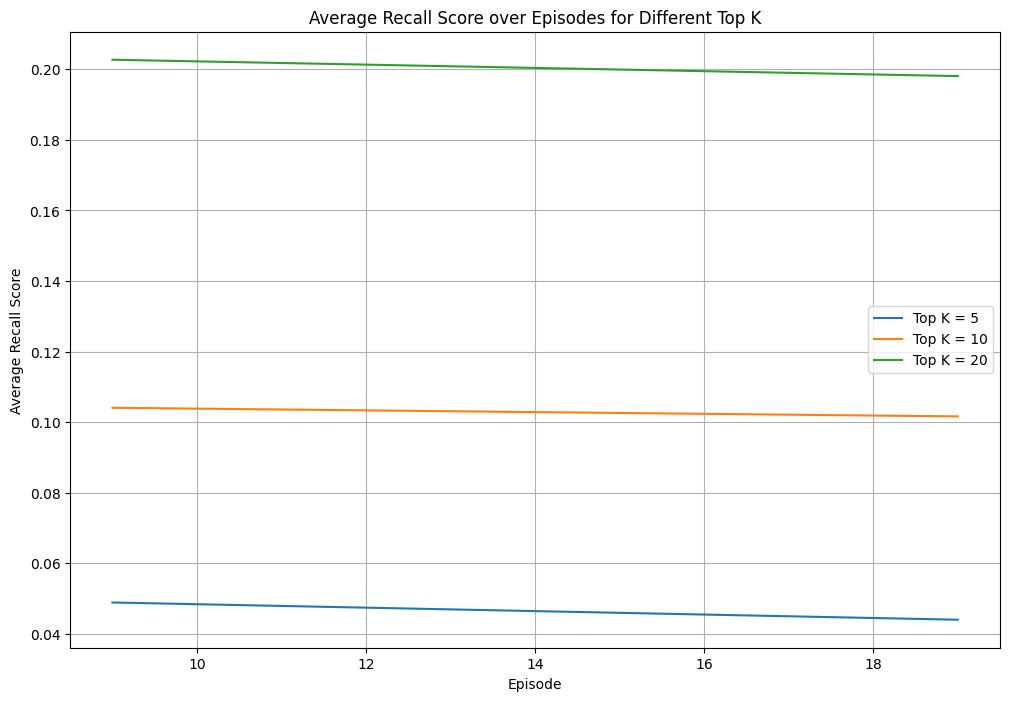

In [5]:
plt.figure(figsize=(12, 8))
for top_K, scores in recall_scores.items():
    episodes, avg_scores = zip(*scores) 
    plt.plot(episodes, avg_scores, label=f'Top K = {top_K}')

plt.xlabel('Episode')
plt.ylabel('Average Recall Score')
plt.title('Average Recall Score over Episodes for Different Top K')
plt.legend()
plt.grid(True)
plt.show()

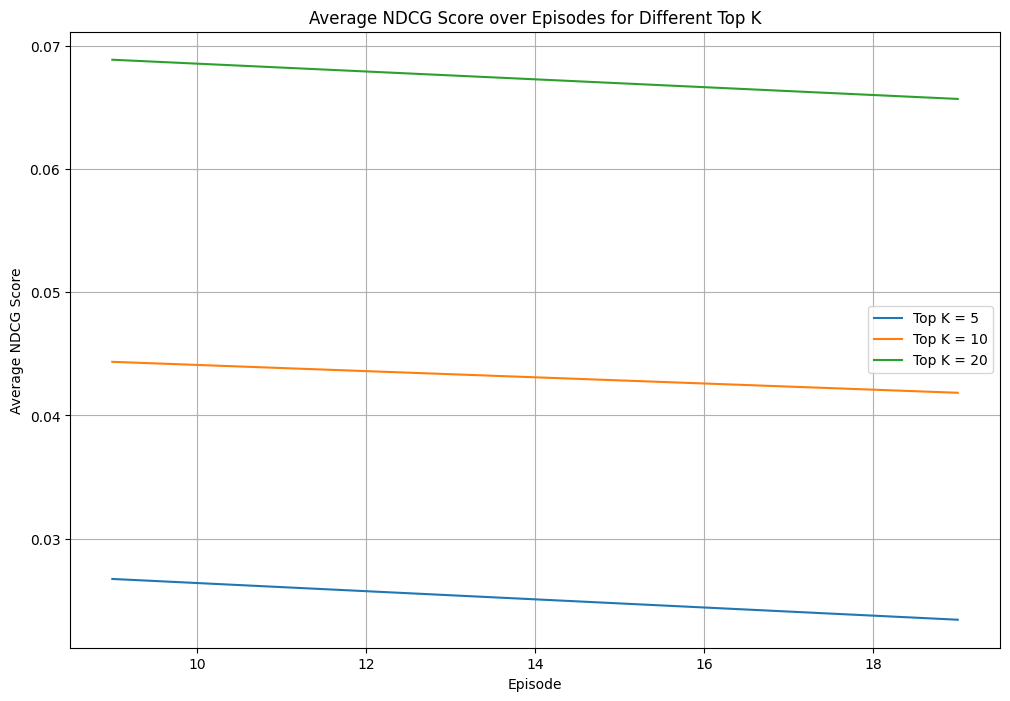

In [6]:
plt.figure(figsize=(12, 8))
for top_K, scores in ndcg_scores.items():
    episodes, avg_scores = zip(*scores) 
    plt.plot(episodes, avg_scores, label=f'Top K = {top_K}')

plt.xlabel('Episode')
plt.ylabel('Average NDCG Score')
plt.title('Average NDCG Score over Episodes for Different Top K')
plt.legend()
plt.grid(True)
plt.show()